In [2]:
!pip install -q efficientnet

In [3]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import os
import cv2
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from transformers import get_cosine_schedule_with_warmup
from albumentations import *
#from kaggle_datasets import KaggleDatasets



In [7]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn
from albumentations import *

In [8]:
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [9]:
SEED = 42
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
#BATCH_SIZE = 8 * 8
SIZE = [224,224]
LR = 0.0008
WEIGHT_DECAY = 0
EPOCHS = 40
WARMUP = 15
TTA = 4

In [10]:
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

seed_everything(SEED)

In [11]:
DIR_INPUT = '/Users/harithatamvada/soil-classification/'
train_df = pd.read_csv(DIR_INPUT + '/train3.csv')
test_df = pd.read_csv(DIR_INPUT + '/train3.csv')
cols = list(train_df.columns[1:])

In [12]:
train_df.head()

,image_id,sand,silt,clay,loam
0,Sample1,0,0,1,0
1,Sample2,0,0,1,0
2,Sample3,0,0,1,0
3,Sample4,0,0,1,0
4,Sample5,0,0,1,0


In [13]:
train,valid = train_test_split(train_df,test_size = 0.2,random_state = SEED)

In [14]:
transform = {
    'train' :Compose([
        Resize(SIZE[0],SIZE[1],always_apply=True),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Rotate(limit=25.0,p=0.8)]) }

def preprocess(df,test=False):
    paths = df.image_id.apply(lambda x: '/Users/harithatamvada/soil-classification' + '/images2/' + x + '.jpg').values
    labels = df.loc[:,'loam':].values
    if test==False:
        return paths,labels
    else:
        return paths
    
def decode_image(filename, label=None, image_size=(SIZE[0], SIZE[1])):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3) 
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    image = tf.image.per_image_standardization(image)
    if label is None:
        return image
    else:
        return image, label
    
def data_augment(image, label=None, seed=SEED):
    image = tf.image.rot90(image,k=np.random.randint(4))
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    if label is None:
        return image
    else:
        return image, label
    
def albu(image):
    transforms = transform['train']
    image = transforms(image=image.numpy())['image']
    image = tf.cast(image, tf.float32)
    return image
    
def albu_fn(image,label=None):
    [image,] = tf.py_function(albu, [image], [tf.float32])
    if label is None:
        return image
    else:
        return image, label

In [15]:
train_dataset = (tf.data.Dataset
    .from_tensor_slices(preprocess(train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .shuffle(SEED)
    .batch(BATCH_SIZE,drop_remainder=True)
    .repeat()
    .prefetch(AUTO))

valid_dataset = (tf.data.Dataset
    .from_tensor_slices(preprocess(valid))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO))

test_dataset = (tf.data.Dataset
    .from_tensor_slices(preprocess(test_df,test=True))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE))

Metal device set to: Apple M2


2023-02-25 15:57:03.732470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 15:57:03.732965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


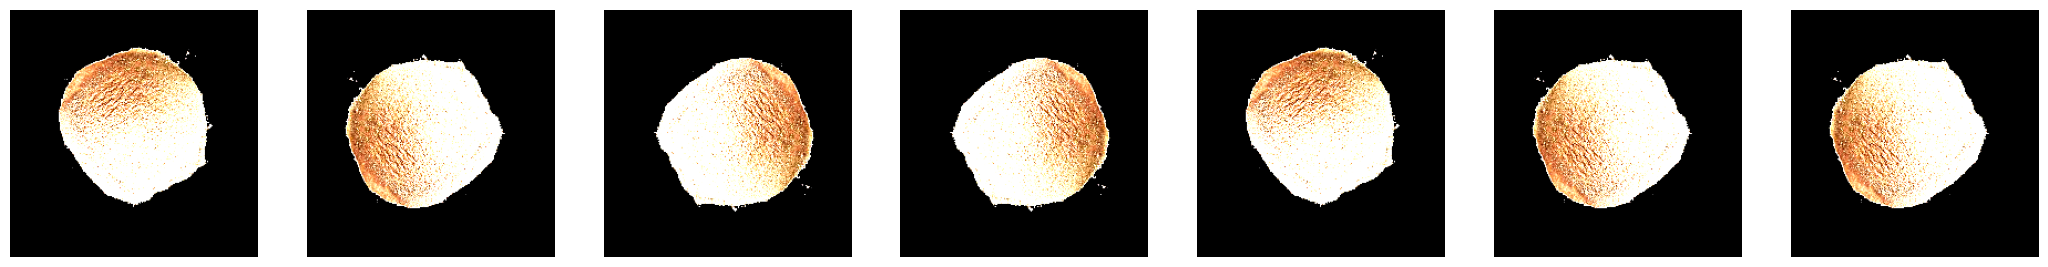

In [16]:
def plot_transform(image_id,num_images=7):
    plt.figure(figsize=(30,10))
    path,_ = preprocess(train.iloc[image_id:image_id+1])
    for i in range(1,num_images+1):
        plt.subplot(1,num_images+1,i)
        plt.axis('off')
        image = decode_image(filename=path[0])
        image = data_augment(image=image)
        plt.imshow(image)

plot_transform(9)

In [17]:
model = tf.keras.Sequential([
    efn.EfficientNetB0(input_shape=(SIZE[0], SIZE[1], 3),weights='imagenet',pooling='avg',include_top=False),
    Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['categorical_accuracy'])

In [18]:
def get_cosine_schedule_with_warmup(lr,num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tenserflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

lr_schedule= get_cosine_schedule_with_warmup(lr=LR,num_warmup_steps=WARMUP,num_training_steps=EPOCHS)

In [19]:
STEPS_PER_EPOCH = train.shape[0] // BATCH_SIZE

def train():
    history = model.fit(
        train_dataset, 
        epochs=EPOCHS, 
        callbacks=[lr_schedule],
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=valid_dataset)
    
    string = 'Train acc:{:.4f} Train loss:{:.4f},Val acc:{:.4f} Val loss:{:.4f}'.format( \
        model.history.history['categorical_accuracy'][-1],model.history.history['loss'][-1],\
        model.history.history['val_categorical_accuracy'][-1],model.history.history['val_loss'][-1])
    
    return string

In [20]:
train()


Epoch 1: LearningRateScheduler setting learning rate to 0.0.
Epoch 1/40


2023-02-25 15:57:15.693968: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 15:57:15.698305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 0.8091 - categorical_accuracy: 0.3438

2023-02-25 15:57:20.615097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 8s 292ms/step - loss: 0.8091 - categorical_accuracy: 0.3438 - val_loss: 0.9953 - val_categorical_accuracy: 0.2308 - lr: 0.0000e+00

Epoch 2: LearningRateScheduler setting learning rate to 5.333333333333333e-05.
Epoch 2/40
12/12 [==============================] - 2s 182ms/step - loss: 0.7099 - categorical_accuracy: 0.4896 - val_loss: 0.8448 - val_categorical_accuracy: 0.3077 - lr: 5.3333e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.00010666666666666667.
Epoch 3/40
12/12 [==============================] - 2s 181ms/step - loss: 0.4121 - categorical_accuracy: 0.7604 - val_loss: 0.5616 - val_categorical_accuracy: 0.8462 - lr: 1.0667e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00016.
Epoch 4/40
12/12 [==============================] - 2s 173ms/step - loss: 0.2646 - categorical_accuracy: 0.7708 - val_loss: 0.3430 - val_categorical_accuracy: 0.8462 - lr: 1.6000e-04

Epoch 5: LearningRateScheduler setting learning rat

12/12 [==============================] - 2s 168ms/step - loss: 0.0480 - categorical_accuracy: 0.8021 - val_loss: 0.0222 - val_categorical_accuracy: 0.9231 - lr: 2.2969e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.00018566928200840126.
Epoch 33/40
12/12 [==============================] - 2s 168ms/step - loss: 0.0113 - categorical_accuracy: 0.7604 - val_loss: 0.0171 - val_categorical_accuracy: 0.9231 - lr: 1.8567e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0001450304041005241.
Epoch 34/40
12/12 [==============================] - 2s 168ms/step - loss: 0.0069 - categorical_accuracy: 0.7708 - val_loss: 0.0208 - val_categorical_accuracy: 0.9231 - lr: 1.4503e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.00010841254903143547.
Epoch 35/40
12/12 [==============================] - 2s 168ms/step - loss: 0.0049 - categorical_accuracy: 0.7812 - val_loss: 0.0199 - val_categorical_accuracy: 0.9231 - lr: 1.0841e-04

Epoch 36: LearningRateSchedule

'Train acc:0.7708 Train loss:0.0033,Val acc:0.8846 Val loss:0.0297'

In [40]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(15,15), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

/var/folders/rq/fttfpph53671nf5_9s4qnwlm0000gn/T/ipykernel_59458/1133020224.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


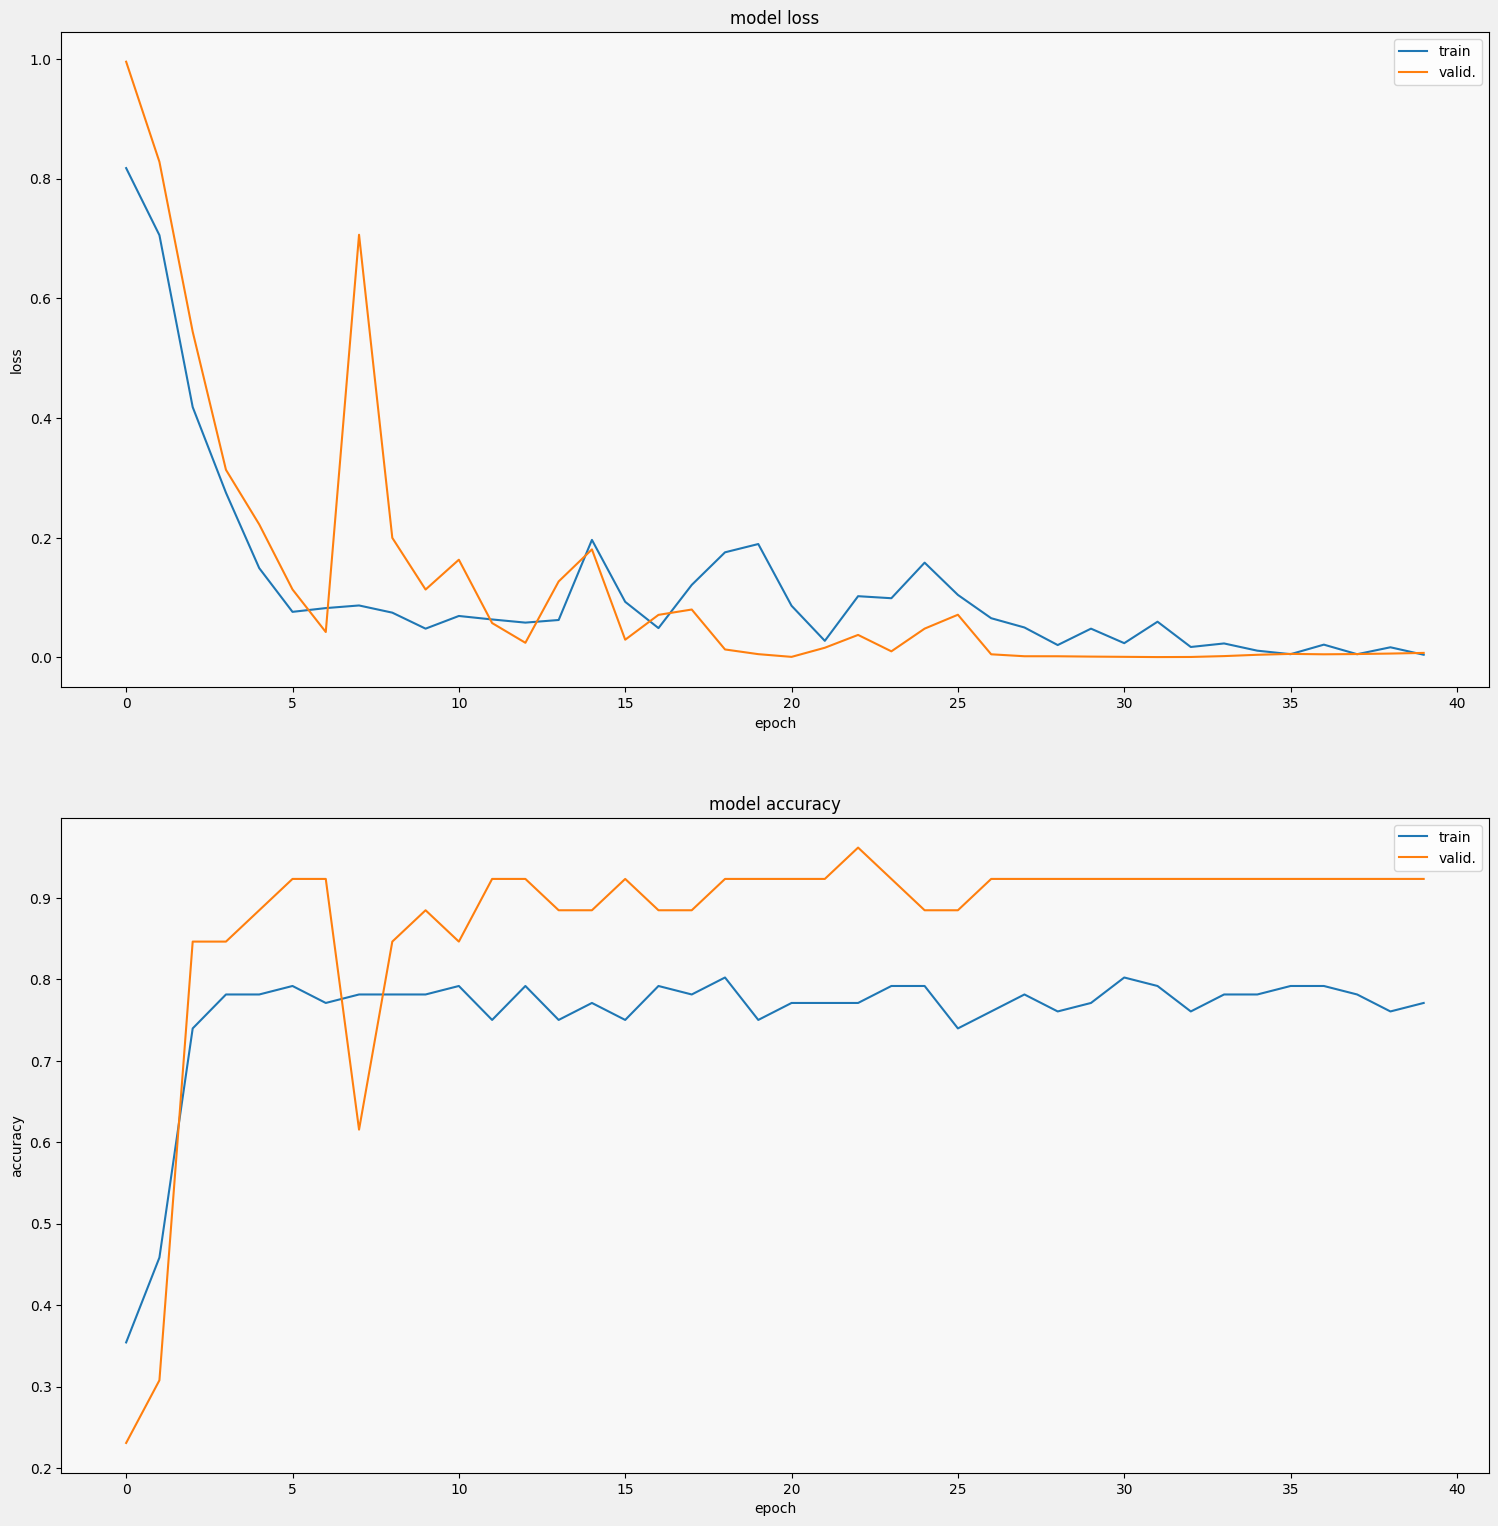

In [41]:
display_training_curves(
    model.history.history['loss'], 
    model.history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    model.history.history['categorical_accuracy'], 
    model.history.history['val_categorical_accuracy'], 
    'accuracy', 212)


In [1]:
from PIL import Image

test_image=r'/Users/harithatamvada/soil-classification/images2/test/5.jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
print(np.argmax(result))
Categories=['clay', 'sand', 'loam', 'silt']
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()

NameError: name 'np' is not defined

In [55]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/rq/fttfpph53671nf5_9s4qnwlm0000gn/T/tmpjjq81ba2/assets


INFO:tensorflow:Assets written to: /var/folders/rq/fttfpph53671nf5_9s4qnwlm0000gn/T/tmpjjq81ba2/assets
2023-02-25 12:45:02.915173: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-25 12:45:02.915189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-25 12:45:02.915612: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/rq/fttfpph53671nf5_9s4qnwlm0000gn/T/tmpjjq81ba2
2023-02-25 12:45:02.941308: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-02-25 12:45:02.941316: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/rq/fttfpph53671nf5_9s4qnwlm0000gn/T/tmpjjq81ba2
2023-02-25 12:45:03.020126: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-25 12:45:03.036544: I tensorflow/cc/saved_model/load